# **ViTs para Agave – De Software a Hardware**


### Integrantes del equipo N° #31:
- Arian Yolanda Reyes Aguilar - A01795124
- Oscar Nava Jiménez - A01745524
- Bruno Sánchez García - A01378960

### Asesor del Proyecto: Diego Concepción Villatoro Gerónimo

### Director del Proyecto: Luis Eduardo Falcón Morales
### Proyecto Integrador | Fecha de Entrega: 28/09/2025

### **Propósito de Proyecto**
El proyecto tiene como objetivo implementar y validar un modelo de visión
computacional basado en Vision Transformers (ViTs) para detectar
automáticamente plantas de agave y evaluar su estado de salud mediante
imágenes capturadas en campo. El modelo, desarrollado en PyTorch bajo la
arquitectura bit-STED, ya ha sido probado exitosamente en software. Ahora se
busca llevarlo a una plataforma embebida, específicamente una Raspberry Pi 5,
para evaluar su rendimiento, eficiencia y viabilidad en condiciones reales con
recursos limitados. Esta prueba en hardware permitirá determinar si la solución
es apta para su implementación directa en el entorno agrícola.


### **Contexto sobre Imagenes**

El dataset consta de aproximadamente 2440 imágenes multiespectrales de tamaño 224x224 píxeles, capturadas en cinco campos agrícolas diferentes. Cada imagen está compuesta por múltiples bandas espectrales que incluyen azul (450 nm), verde (560 nm), rojo (650 nm), borde rojo (730 nm) y el infrarrojo cercano (840 nm). Estas imágenes fueron tomadas con drones equipados con sensores especializados, y están destinadas a permitir el análisis detallado de plantas de agave mediante técnicas de visión por computadora. El formato de las imágenes es TIFF multibanda, lo que permite conservar la información espectral necesaria para detectar y evaluar el estado de salud de las plantas.

### **Objetivo de Actividad**

Transformar las imágenes multiespectrales crudas en características útiles para el modelo bit-STED, mediante la generación de índices espectrales, normalización y reducción dimensional con PCA. Estas técnicas buscan mejorar la eficiencia y precisión del modelo, optimizando su rendimiento para su implementación en una Raspberry Pi 5. Además, se justificará y evaluará la selección y extracción de características, siguiendo la metodología CRISP-ML, para asegurar un preprocesamiento adecuado y adaptado a un entorno agrícola.

### Ingeniería de Características para Dataset de Detección de Objetos (Imágenes + Etiquetas YOLO)

Este notebook extrae **características numéricas** significativas a partir de imágenes y sus anotaciones de cuadros delimitadores asociadas (formato YOLO). Soporta:

- **Características basadas en color y forma** (estadísticas por canal, geometría de cajas)  
- **Características de disposición espacial** (posición y dispersión de cajas)  
- **Características de textura** mediante HOG (Histograma de Gradientes Orientados)  

#### Estructura de Dataset Asumida:

```plaintext
Zones_cbbox_dataset_10-20250928T004644Z-1-001/
└── Zones_cbbox_dataset_10/
    └── train/
        ├── images/   ← .tif files
        └── labels/   ← .txt files (YOLO format with 4 entries per line)
```

### ¿Qué son las Características de Textura (HOG)?

**HOG** (Histograma de Gradientes Orientados) captura:  
- Orientaciones y frecuencias locales de bordes  
- Patrones de textura detallados  
- Útil para detectar regiones estructuradas como líneas, esquinas y formas de objetos  

### ¿Por qué incluirlas?  
- Proporcionan información **complementaria** a las estadísticas de píxeles y geometría de cuadros  
- Mejoran el desempeño en modelos tradicionales de ML (e.g., SVM, Random Forest)  
- Especialmente útiles cuando no se usan CNNs para extracción directa de características  

Importación de Librerías y Configuración de Rutas

In [1]:
# Importamos Librerías
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from glob import glob
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage import io as skio
import rasterio

Cargar Lista de Imágenes y Etiquetas

In [2]:
# Definir Rutas de Imágenes y Etiquetas
IMAGES_DIR = "Zones_cbbox_dataset_10/train/images"
LABELS_DIR = "Zones_cbbox_dataset_10/train/labels"

# Obtener lista de imágenes TIFF
imagenes = sorted(glob(os.path.join(IMAGES_DIR, "*.tif")))
etiquetas = sorted(glob(os.path.join(LABELS_DIR, "*.txt")))

# Mostrar total de imágenes y etiquetas
print(f"Total Imágenes: {len(imagenes)}")
print(f"Total Etiquetas: {len(etiquetas)}")


Total Imágenes: 2440
Total Etiquetas: 2440


Estadísticas de Resolución y Canales de las Imágenes

In [3]:
# Inicializar listas
dimensions = []
num_channels = []
images_unreadable = []

# Procesar cada imagen
for img_path in imagenes:
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        images_unreadable.append(img_path)
        continue

    height, width = img.shape[:2]
    channels = img.shape[2] if len(img.shape) == 3 else 1

    dimensions.append((width, height))
    num_channels.append(channels)

# Mostrar estadísticas
print(f"Total Imágenes Analizadas: {len(dimensions)}")
print(f"Imágenes no Leídas: {len(images_unreadable)}")

if dimensions:
    widths, heights = zip(*dimensions)
    print("\nEstadísticas de Resolución:")
    print(f" - Promedio: {int(np.mean(widths))} x {int(np.mean(heights))} px")
    print(f" - Mínimo: {min(widths)} x {min(heights)} px")
    print(f" - Máximo: {max(widths)} x {max(heights)} px")

if num_channels:
    distribution = Counter(num_channels)
    print("\nDistribución de Canales por Imagen:")
    for c, count in distribution.items():
        print(f" - {c} Canales: {count} Imágenes")


Total Imágenes Analizadas: 2440
Imágenes no Leídas: 0

Estadísticas de Resolución:
 - Promedio: 224 x 224 px
 - Mínimo: 224 x 224 px
 - Máximo: 224 x 224 px

Distribución de Canales por Imagen:
 - 3 Canales: 2440 Imágenes


Funciones para Calcular Indices Espectrales Multibanda

In [4]:
def calculate_spectral_indices(img):
    # bands, height, width
    R = img[0].astype(np.float32)
    G = img[1].astype(np.float32)
    B = img[2].astype(np.float32)

    eps = 1e-6

    ExG = 2 * G - R - B
    ExR = 1.4 * R - G
    GRI = (G + eps) / (R + eps)
    VARI = (G - R) / (G + R - B + eps)

    indices_stats = {}
    for name, index in zip(['ExG', 'ExR', 'GRI', 'VARI'], [ExG, ExR, GRI, VARI]):
        indices_stats[f"{name}_mean"] = np.mean(index)
        indices_stats[f"{name}_std"] = np.std(index)
        indices_stats[f"{name}_min"] = np.min(index)
        indices_stats[f"{name}_max"] = np.max(index)

    return indices_stats

Funciones para Calcular PCA

In [5]:
def calculate_pca_variance(img):
    # Reshape imagen para PCA: pixeles x bandas
    pixels = img.reshape(img.shape[0], -1).T
    # Centrar datos
    pixels -= np.mean(pixels, axis=0)
    # Covarianza
    cov = np.cov(pixels, rowvar=False)
    # Valores propios
    eigvals, _ = np.linalg.eigh(cov)
    eigvals = np.flip(np.sort(eigvals))
    # Normalizar
    eigvals /= eigvals.sum()
    return {"PC1_var": eigvals[0], "PC2_var": eigvals[1], "PC3_var": eigvals[2]}

Función para Parsear Etiquetas YOLO

In [6]:
def parse_yolo_labels(txt):
    boxes = []
    for line in txt.strip().split("\n"):
        parts = line.strip().split()
        if len(parts) != 4:
            continue
        cls, xc, yc, size = map(float, parts)
        boxes.append({
            "class": int(cls),
            "x_center": xc,
            "y_center": yc,
            "width": size,
            "height": size,
            "area": size * size
        })
    return boxes

Extracción de Características

In [7]:
features = []

for img_path in imagenes:
    name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(LABELS_DIR, f"{name}.txt")
    if not os.path.exists(label_path):
        print(f"[!] Etiqueta faltante para {name}")
        continue

    # Leer imagen multibanda con rasterio
    with rasterio.open(img_path) as src:
        img = src.read()

    h, w = img.shape[1:]
    aspect_ratio = w / h if h > 0 else 0

    # Índices RGB y PCA
    indices = calculate_spectral_indices(img)
    pca_var = calculate_pca_variance(img)

    # Preparar imagen RGB para HOG
    rgb_img = img[:3].transpose(1, 2, 0)

    # Normalizar y convertir a uint8 para HOG
    if rgb_img.dtype != np.uint8:
        rgb_min, rgb_max = rgb_img.min(), rgb_img.max()
        if rgb_max > rgb_min:
            rgb_img = ((rgb_img - rgb_min) / (rgb_max - rgb_min) * 255).astype(np.uint8)
        else:
            rgb_img = np.zeros_like(rgb_img, dtype=np.uint8)

    # Redimensionar y convertir a escala de grises
    rgb_img_resized = cv2.resize(rgb_img, (128, 128))
    gray = cv2.cvtColor(rgb_img_resized, cv2.COLOR_RGB2GRAY)

    # Calcular HOG
    hog_feat, _ = hog(
        gray,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=True,
        feature_vector=True
    )

    if hog_feat.size > 0:
        hog_mean, hog_std = hog_feat.mean(), hog_feat.std()
    else:
        hog_mean, hog_std = 0.0, 0.0

    # Leer etiquetas YOLO
    with open(label_path, "r") as f:
        boxes = parse_yolo_labels(f.read())

    if boxes:
        widths = [b["width"] for b in boxes]
        heights = [b["height"] for b in boxes]
        areas = [b["area"] for b in boxes]
        x_centers = [b["x_center"] for b in boxes]
        y_centers = [b["y_center"] for b in boxes]
    else:
        widths = heights = areas = x_centers = y_centers = [0]

    features.append({
        "image_name": name,
        "img_width": w,
        "img_height": h,
        "hog_mean": hog_mean,
        "hog_std": hog_std,
        "aspect_ratio": aspect_ratio,
        "num_boxes": len(boxes),
        "avg_box_width": np.mean(widths),
        "avg_box_height": np.mean(heights),
        "avg_box_area": np.mean(areas),
        "avg_x_center": np.mean(x_centers),
        "avg_y_center": np.mean(y_centers),
        **indices,
        **(pca_var or {})
    })

In [8]:
df_features = pd.DataFrame(features)
print("\nFeatures extraídas:")
print(df_features.head())



Features extraídas:
  image_name  img_width  img_height  hog_mean   hog_std  aspect_ratio  \
0       1001        224         224  0.328323  0.057578           1.0   
1       1002        224         224  0.212772  0.166267           1.0   
2       1003        224         224  0.137996  0.176930           1.0   
3       1004        224         224  0.291943  0.124352           1.0   
4       1005        224         224  0.333099  0.012491           1.0   

   num_boxes  avg_box_width  avg_box_height  avg_box_area  ...   GRI_std  \
0         11       0.047540        0.047540      0.002463  ...  0.342678   
1          5       0.049341        0.049341      0.002510  ...  0.260137   
2          3       0.045078        0.045078      0.002055  ...  0.228289   
3          7       0.039188        0.039188      0.001655  ...  0.369939   
4         12       0.047772        0.047772      0.002492  ...  0.364056   

    GRI_min   GRI_max  VARI_mean  VARI_std   VARI_min   VARI_max   PC1_var  \
0  0.

 Gráfico de Distribución

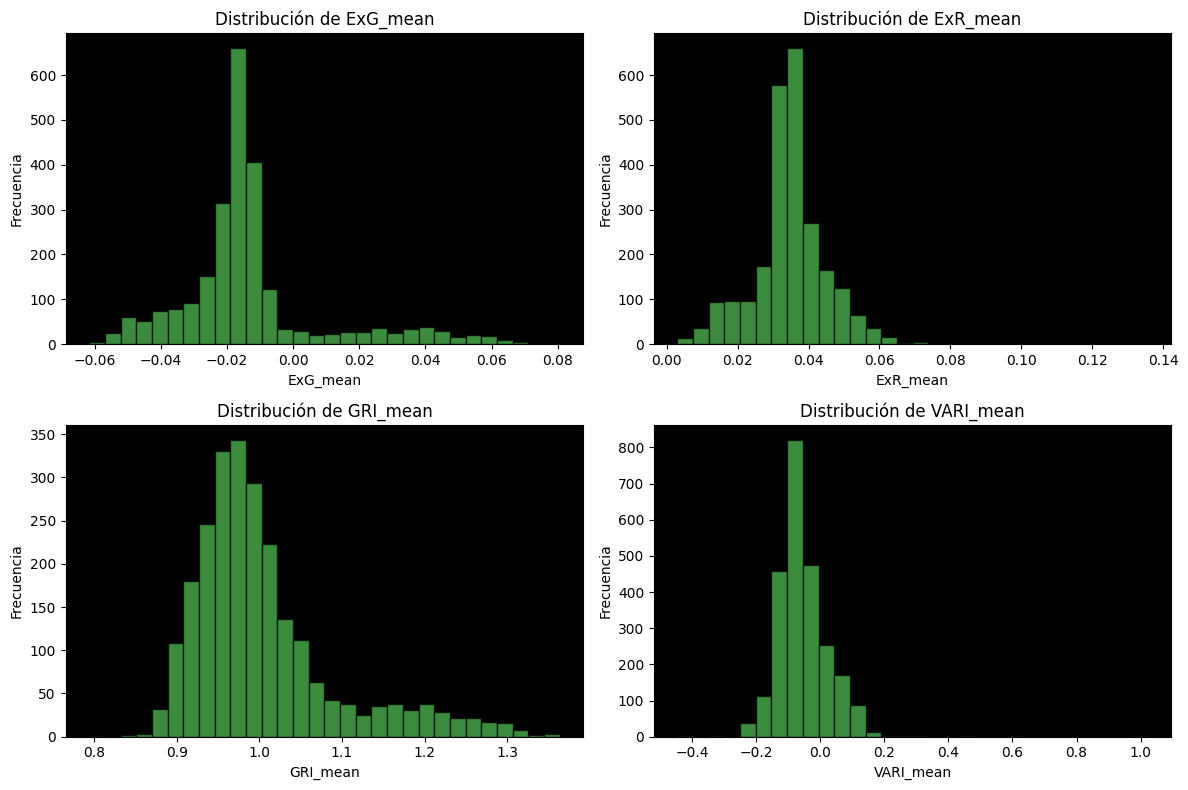

In [9]:
# Índices a graficar
indices_to_plot = ["ExG_mean", "ExR_mean", "GRI_mean", "VARI_mean"]

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Generar histogramas
for i, idx in enumerate(indices_to_plot):
    if idx in df_features.columns:
        axes[i].hist(df_features[idx], bins=30, alpha=0.7, color="#56C958", edgecolor='black')
        axes[i].set_title(f"Distribución de {idx}")
        axes[i].set_xlabel(idx)
        axes[i].set_ylabel("Frecuencia")
        axes[i].set_facecolor('black') 

# Ajustar diseño
plt.tight_layout()
plt.show()

Conclusion

Con base en los resultados obtenidos tras la extracción de características, se puede concluir que el proceso de preparación de datos ha logrado generar un conjunto de atributos numéricos representativos y variados para cada imagen multiespectral. Entre las características extraídas se incluyen métricas geométricas de las cajas delimitadoras (como tamaño promedio, área y cantidad de objetos detectados), propiedades de textura (HOG), y una diversidad de índices espectrales (ExG, ExR, GRI, VARI), así como componentes principales obtenidos mediante PCA. Estas variables presentan una variabilidad que refleja diferencias relevantes entre imágenes, lo cual es crucial para tareas posteriores de clasificación o detección. La inclusión de múltiples tipos de atributos (geométricos, espectrales y de textura) permite capturar información complementaria, lo que puede mejorar el desempeño de modelos de aprendizaje automático. En el contexto de la metodología CRISP-ML, esta etapa de preparación de los datos ha sido completada de forma sistemática, asegurando que el dataset resultante esté listo para fases posteriores como modelado y evaluación.

Referencias

Dalal, N., & Triggs, B. (2005). Histograms of oriented gradients for human detection. In Proceedings of the 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05) (Vol. 1, pp. 886–893). IEEE. https://doi.org/10.1109/CVPR.2005.177

van der Walt, S., Schönberger, J. L., Nunez-Iglesias, J., Boulogne, F., Warner, J. D., Yager, N., Gouillart, E., Yu, T., & the scikit-image contributors. (2014). scikit-image: Image processing in Python. PeerJ, 2, e453. https://doi.org/10.7717/peerj.453

Ultralytics. (2023). YOLOv5 by Ultralytics [Computer software]. GitHub. https://github.com/ultralytics/yolov5

Karpathy, A., & Li, F. F. (n.d.). CS231n: Convolutional Neural Networks for Visual Recognition. Stanford University. https://cs231n.github.io/

Howard, J., & Gugger, S. (2020). Practical Deep Learning for Coders [Online course]. fast.ai. https://course.fast.ai/